# Evaluating Implications of Problematic Routing Assumptions in Spatially Explicit Agent-Based Models of Wildfire Evacuation

## Code demonstration notebook

This notebook demonstrates code to run a wildfire evacuation agent based model. This notebook is a companion to the forthcoming manuscript, "Evaluating Implications of Problematic Routing Assumptions in Spatially Explicit Agent-Based Models of Wildfire Evacuation" by Rebecca Vandewalle, Jeon-Young Kang, and Shaowen Wang.

Notebook author: Rebecca Vandewalle
<br>Last updated: 2-26-21

<a id='top'></a>
## Table of Contents
- [Introduction](#intro)
- [Quick Start](#quick_start)
- [Import Libraries and Setup](#import_lib)
- [Model Overview](#mod_overview)
- [Driving Strategy Demonstration](#drive_demo)
- [Working With and Customizing Input Data](#cust_input)
- [Scaling Up](#scaling_up)
- [Analyzing Simulation Results](#analyz_res)

<a id='intro'></a>
## Introduction

The main code base is flexible and can serve a variety of purposes; not all available parameters are used in the manuscript. Broadly, the code models the process of evacuation on a road network in which roads are progressively closed by wildfire spread. Individual households, represented by a vehicle, must navigate out of the danger zone and re-route if the road they are currently on becomes blocked by the wildfire. The forthcoming manuscript specifically looks at patterns in evacuation clearance and congestion that change based on how vehicle routing decisions are modeled. Specifically three driving strategies are compared, 2 based off of common modeling assumptions (quickest path and shortest path), and one that attempts to more closely model evacuee behavior (preference for major roads). These strategies and the assumptions behind them are described in more detail in the manuscript and demonstrated in this notebook.

### Manuscript research questions

- **R1.** How does routing preference (shortest path vs. quickest path vs. major roads) affect evacuation clearance times?
- **R2.** How does congestion differ between routing strategies over space and time? 

### How the code addresses the research questions

This code base described in the manuscript and in this notebook is used to run wildfire evacuation simulations for the same set of random seeds for each of the three driving strategies. The seed values control the initial vehicle placement. Every other parameter is the same for each simulation run except for the driving strategy used. This results in a repeated measures experiment setup; every initial vehicle configuration is run with all three driving strategies. Simulation timing and spatial-temporal congestion patterns are compared between the driving strategies to see how the strategy effects time time needed for vehicles to leave the evacuation zone and how traffic patterns potentially differ.

### Notebook Overview

The quick start section demonstrates a fastest way to run a single simulation. Subsequent sections will provide an overview of the model, demonstrate driving strategies, show how to customize input data, discuss scaling up using high performance computing resources, and finally mention analyzing output results.

For a more detailed discussion of certain aspects of the model, refer to the help files in the `DOCUMENTATION` folder.

<a id='quick_start'></a>
## Quick Start
([back to Table of Contents](#top))

In [1]:
# determine current path and make output directory for quick start

import os
out_path = os.getcwd() # save current path 
if not os.path.isdir('demo_quick_start'): # create quick start output directory
    os.mkdir('demo_quick_start')

The following line of code runs the wildfire agent-based model evacuation simulation one time and saves the results in the `demo_quick_start` folder. 

Important parameters (these will be described in more depth later on):
- `-nv`: number of vehicles to include in the simulation
- `-sd`: seed, this number is used to set the randomization of the initial vehicle positions
- `-epath`: current path
- `-ofd`: name of the output directory used to store results
- `-strat`: driving strategy used (`quickest`, `dist`, or `dist+road_type_weight`)
- `-rg`: formatted Osmnx road graph stored as a pickle file
- `-exdsc`: experiment description (a tag to help keep track of runs)

In [2]:
# run a small simulation

!python run_fireabm.py -nv 10 -sd 1 -epath "$out_path" \
-ofd demo_quick_start -strat dist -rg Sta_Rosa_2000.pkl \
-exdsc 'demo_run' -strd 1.0


!! starting file parse at: 21:27:42

!! checking input parameters
!! input parameters OK

!! starting full run at 21:27:42 

!! run simulation

run params: 100% shortest distance i: 0 j: 1 SEED: 1 strat_perc 1.0
fire initially spreads.... 1.0
END init
fire spreads.... 2.0

success! no: 1 run_time: 0:00:29.335239 timestamp: 21:28:11

bad_seeds []

!! ending full run at 21:28:11, elapsed time: 0:00:29.335449
!! runs completed: 1 / 1
!! Full simulation block complete!



If you have run the previous cell with the default parameters, you will find three types of results are saved in subfolders for each run:
- in folder `1files`: A file of run information, which stores things like the number of vehicles, seeds, driving strategies, clearance times etc.
- in folder `1trajs`: A file of trajectories taken by each vehicle
- in folder `1videos`: A video of the completed simulation run

Note that the '1' at the start of the folder names is from the experiment number, a flag to help keep track of different groups simulation runs. It is set by default in `run_fireabm.py`.

<a id='import_lib'></a>
## Import Libraries and Setup
([back to Table of Contents](#top))

Here libraries and modules used in this notebook are imported and a few helper variables and functions are defined.

In [61]:
# import libraries

import os
import glob
import IPython
from datetime import datetime
from shapely.ops import unary_union
import pytz
from pathlib import Path
from IPython.display import Video

In [4]:
# set notebook parameters

out_path = Path(os.getcwd())
time_zone = pytz.timezone('America/Chicago') 

In [5]:
# import functions and text of FireABM_opt.py

from FireABM_opt import *
fabm_file=open('FireABM_opt.py')
fabm_lines=fabm_file.readlines()

run_fabm_file=open('run_fireabm.py')
run_fabm_lines=run_fabm_file.readlines()

In [6]:
# define helper function for displaying code
# start and stop are 0-indexed, line numbers are 1-indexed

def display_code_txt(start, stop, lines_obj):
    return IPython.display.Code(data="".join([(str(i+start+1)+" "+x) 
                                              for i, x in enumerate(lines_obj[start:stop])]), language='py3')

<a id='mod_overview'></a>
## Model Overview
([back to Table of Contents](#top))

Running the simulation model takes two steps. The simulation needs to be called twice, once to set up the simulation by calling the `__init__` function, and once to actually run the simulation using the `run` function.

Here the simulation `__init__` function in `FireABM_opt.py` is shown. Not all parameters are used in manuscript experiments; relavent parameters are defined below.

In [7]:
# show the simulation init section

display_code_txt(1105, 1106, fabm_lines)

1106     def __init__(self, g, n, bbox=None, fire_perim=None, fire_ignit_time=None, fire_act_ts_min=60, fire_des_ts_sec=10, sim_type="main", sim_number=0, reset_interval=False, start_vehicle_positons=None, nav_weight_list=None, placement_prob=None, init_strategies=None):

NetABM `__init__` input parameter description:
- `g` - road graph: the input Osmnx road graph 
- `n` - number of vehicles: the total number of vehicles used in the simulation run 
- `bbox` - bounding box: the bounding box of the evacuation zone, lbbox is created by the create_bboxes function with the following buffer [2.1, 4.5, 3, 3]
- `fire_perim` - fire perimeter: shapefile of fire perimeters 
- `fire_ignit_time` - fire ignition time: 'SimTime' value for the first perimeter used in the simulation, can be adjusted to start with a later perimeter, 60 is used because is the first output fire perimeter
- `fire_des_ts_sec` - fire update time intervals to seconds: translates intervals between fire times to seconds, used to speed up or slow down a fire spread from the input shapefile, for these experiments 100 is used, so that the fire expands every 100 timesteps (seconds)
- `reset_interval` - reset fire interval: flag used to indicate the fire time has been translated
- `placement_prob` - vehicle placement probability: value name containing the placement probabilities per initial vehicle placements
- `init_strategies` - initial vehicle strategies: dictionary indicating which driving strategies are used and the percentage of vehicles that should be assigned to each strategy

Here the simulation `run` function in `FireABM_opt.py` is shown. Not all parameters are used in manuscript experiments; relevant parameters are defined below.

In [8]:
# show the simulation run section

display_code_txt(1387, 1388, fabm_lines)

1388     def run(self, nsteps=None, mutate_rate=0.005, update_interval=100, save_args=None, opt_interval=35, strategies=['dist', 'dist+speed'], opt_reps=1, mix_strat=True, congest_time=25):

NetABM `run` input parameter description:
- `mutate_rate` - the road segment closure rate: ignored if a fire shapefile is given, if no fire shapefile it is the rate at which road segments will randomly become blocked at an update interval
- `update interval` - the road closure interval: used for to determine how often the mutate rate will check to close roads
- `save_args` - save file arguments: used to create simulation animation, contains `fig`, `ax` created by the `setup_sim` function, the result file name, the video file name, the folder name for storing the results, i and j which can be used to keep track of iterating through seeds and driving strategies, the seed used, the short tag describing the treatment, the short text describing the experiment, the experiment number and notebook number, and which road graph file is used. More detailed on these can be found in the 'Simulation output structure and explanation' help document
- `congest_time` - congestion time: interval at which congestion is recorded

Note that `nsteps`, `opt_interval`, `strategies`, `opt_reps`, and `mix_strat` are not used for the current set of experiments.

### Running an example simulation on the full road graph

`run_fireabm.py` calls both the `__init__` and `run` functions as seen below.

In [9]:
# show the simulation __init__ section of run_fireabm.py

display_code_txt(165, 168, run_fabm_lines)

166                 simulation = NetABM(road_graph, args.num_veh, bbox=lbbox, fire_perim=sr_fire, fire_ignit_time=args.start_fire_time, 
167                 fire_des_ts_sec=100, reset_interval=True, placement_prob='Pct_HH_Cpd', 
168                 init_strategies={major_strat:strat_perc})

In [10]:
# show the simulation run section of run_fireabm.py

display_code_txt(169, 172, run_fabm_lines)

170                 simulation.run(save_args=(fig, ax, args.rslt_file_name, args.vid_file_name, args.out_folder, 
171                              i, j, seed, treat_desc, args.exp_desc, args.exp_no, args.nb_no, args.road_graph_pkl), mutate_rate=0.005, update_interval=100)
172                 run_count += 1

The following code demonstrates running a larger simulation using the full road graph used for manuscript experiments (`Sta_Rosa_8000.pkl`). Only 200 vehicles are used so that the runtime is ~15 minutes instead of multiple hours. However, since this takes a while, switch `run_long_full_sim` to `True` in order to run the simulation.

In [11]:
# the example full simulation takes ~15 minutes
# change this variable to True to run

run_long_full_sim = False

In [12]:
# run full example (shortest distance driving strategy, 200 vehicles)

if run_long_full_sim:
    if not os.path.isdir('demo_full_example'): # create full example output directory
        os.mkdir('demo_full_example')
    if os.path.isdir(os.path.join("demo_full_example", "1files")):
        print("You have likely already ran this cell: the results will be the same!")
    else:
        !python run_fireabm.py -nv 200 -sd 2 -epath "$out_path" -ofd demo_full_example -strat dist \
        -rg Sta_Rosa_8000.pkl -exdsc 'Demo quickest strat comp to mjrds and dist' -strd 1.0 -rfn 'demo_result' \
        -vfn 'demo_output'
else:
    print("Change 'run_long_full_sim' to True to run this simulation!")

Change 'run_long_full_sim' to True to run this simulation!


Once this has finished running, you can view the output data in the `demo_full_example` folder.

<a id='drive_demo'></a>
## Driving Strategy Demonstration
([back to Table of Contents](#top))

The core element of the experiments run for this manuscript are the three driving strategies. In this section they will be explained in more detail and demonstrated on a small road graph.

The experiments used for this manuscript compare three driving strategies, described below (see the manuscript for more details):


1. **Quickest path:**
    - this driving strategy is commonly used in evacuation models
    
    **How to select the path:**
        - Select the shortest path from the vehicle position to the nearest exit using Dijkstra's algorithm weighted by both **road segment length** and **road segment speed limit**
        - As the simulation progresses, at each time step, for each road segment that has at least one vehicle on it, estimate the current road segment speed by the average speed of all of the vehicles currently on the road segment
        - each time at least one road segment's estimated speed is different from its usual speed (more than a small difference value to adjust for rounding), each vehicle will redetermine the path using the estimated speed in stead of the actual speed for each road segment containing vehicles
        - there typically needs to be a relatively large amount of congestion for it to make sense to take a detour that is longer distance wise
        - A new path, using the same method as described above, will also selected if a road segment on the current path is closed due to the wildfire spread
    
    
2. **Shortest path:**
    - this driving strategy is also commonly used in evacuation models
    
    **How to select the path:**
        - Select the shortest path from the vehicle position to the nearest exit using Dijkstra's algorithm weighted by **road segment length** 
        - A new path will only be selected if a road segment on the current path is closed due to the wildfire spread
    
    
3. **Major roads:**
    - this driving strategy is used in an attempt to more realistically model traffic behavior observed in evacuations
    
    **How to determine the path:**
        - Select the shortest path from the vehicle position to the nearest exit using Dijkstra's algorithm weighted by **road type weight** multiplied by **road segment length**. Road type weights are determined according to the table below. Road type is a value found in OpenStreetMap's 'highway' column.
        - A new path will only be selected if a road segment on the current path is closed due to the wildfire spread
        
        
| OSM Road Type | weight |
|---------------|--------|
|motorway, motorway_link, trunk, trunk_link|1|
|primary, primary_link|5|
|secondary, secondary_link|10|
|tertiary, tertiary_link|15|
|unclassified, residential, (other value)|20|

### Road Strategy Demonstration

First we need to import the road graph. This particular graph only has two exits, both at the bottom left corner, in order to help visualize differences between paths chosen according to each driving strategy.

In [13]:
# import demo road graph used for driving strategy demo

road_graph_pkl = 'demo_road_graph.pkl'
road_graph = load_road_graph(road_graph_pkl)
gdf_nodes, gdf_edges = get_node_edge_gdf(road_graph)
(bbox, lbbox, poly, x, y) = create_bboxes(gdf_nodes, 0.1, buff_adj=[-1, -1, 0.5, -1])

The next cell displays the road graph and the bounding box.

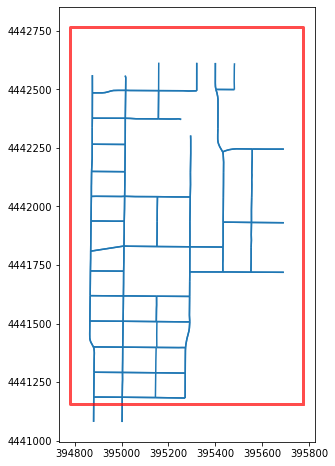

In [14]:
# display road graph

check_graphs(gdf_edges, x, y);

As described above, road segment speeds and road types are important for the different routing strategies, so in the next two cells we view speeds and the road types found in this small road graph. Each segment has the same speed limit, which makes it easier to see differences between driving strategies.

Attribute: speed, Type: int64


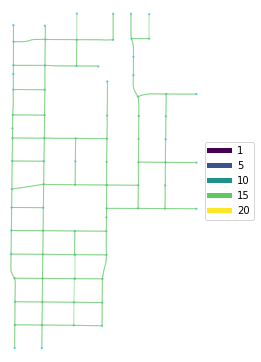

In [15]:
# view speeds

view_edge_attrib(road_graph, 'speed', show_val=True, val=[1, 5, 10, 15, 20]);

Only one street has the designation of "motorway".

Attribute: highway, Type: object


(<Figure size 311.222x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff3b77d7a50>)

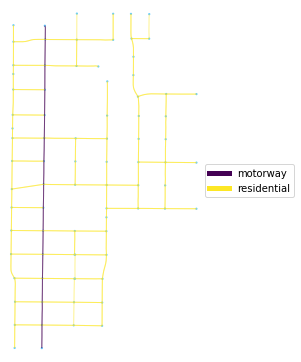

In [16]:
# view road types

view_edge_attrib(road_graph, 'highway')

Now we will run each driving strategy on this small graph with the following code blocks.

In [17]:
# make sure output directory exists

if not os.path.isdir('demo_driving_compare'):
    os.mkdir('demo_driving_compare')

In [18]:
# set run parameters

seed = 2
j = 0
exp_no, nb_no = 0, 0
strats = ['quickest', 'dist', 'dist+road_type_weight']
treat_desc = ['100% quickest', '100% shortest distance', '100% major roads']
exp_desc = 'demo compare driving strats'
vid_path = out_path / "demo_driving_compare" / "0videos"

In [19]:
# run simulations

if os.path.isdir(os.path.join("demo_driving_compare", "0files")):
    print("You have likely already ran this cell: the results will be the same!")
else:
    for i in range(len(strats)):
        print('Starting simulation run for', strats[i])
        start_full_run_time = datetime.now(time_zone)

        road_graph_pkl = 'demo_road_graph.pkl'
        road_graph = load_road_graph(road_graph_pkl)
        gdf_nodes, gdf_edges = get_node_edge_gdf(road_graph)
        (bbox, lbbox, poly, x, y) = create_bboxes(gdf_nodes, 0.1, buff_adj=[-1, -1, 0.5, -1])

        fig, ax = setup_sim(road_graph, seed)
        simulation = NetABM(road_graph, 200, bbox=lbbox, fire_perim=None, fire_ignit_time=None, 
        fire_des_ts_sec=100, reset_interval=False, placement_prob=None, 
        init_strategies={strats[i]:1.0})

        simulation.run(save_args=(fig, ax, 'demo_driving_out', 'demo_driving_vid', 'demo_driving_compare', 
                 i, j, seed, treat_desc[i], exp_desc, exp_no, nb_no, 'demo_road_graph.pkl'), 
                       mutate_rate=0.000, update_interval=100)

    end_full_run_time = datetime.now(time_zone) 
    print('Run complete run at', end_full_run_time.strftime("%H:%M:%S")+',', 'elapsed time:', 
          (end_full_run_time-start_full_run_time))

You have likely already ran this cell: the results will be the same!


Now we can view the result videos. We'll start with the simplest driving strategy, shortest distance. Notice that all the vehicles on and to the right of the motorway road use the right most exit.

In [20]:
# view the shortest distance driving strategy 

dfile = "/".join(glob.glob(str(vid_path)+'/demo_driving_out_1*')[0].split("/")[-3:])
HTML('<video width="300" controls><source src="%s" type="video/mp4"></video>'%dfile)

Now view the quickest driving strategy. Watch closely the vehicles that start at the center top, in this case many of them switch to use the left most exit because of the build up of congestion on the right one.

In [21]:
# view the quickest driving strategy 

qfile = "/".join(glob.glob(str(vid_path)+'/demo_driving_out_0*')[0].split("/")[-3:])
HTML('<video width="300" controls><source src="%s" type="video/mp4"></video>'%qfile)

Finally, here is the major roads simulation. Here very few vehicles take the left most exit because the highway is preferred.

In [22]:
# view the major roads driving strategy 

mfile = "/".join(glob.glob(str(vid_path)+'/demo_driving_out_2*')[0].split("/")[-3:])
HTML('<video width="300" controls><source src="%s" type="video/mp4"></video>'%mfile)

<a id='cust_input'></a>
## Working With and Customizing Input Data
([back to Table of Contents](#top))

In order to run the full evacuation simulation in a different location, you will need to create a new road graph, use a new households file, and import a new wildfire perimeter shapefile. More details about these data and the actions needed to create them for a given study area are discussed below.

### Road Graph

We have now used a road graph to see how each driving strategy uses a different routing methods for evacuees to leave the evacuation zone. In this section we will look in more depth at how a road graph is constructed.

A road graph created with the [OSMnx Python library](https://osmnx.readthedocs.io/) is a form of a [Networkx graph](https://networkx.org/). This graph data structure contains nodes, edges, and data associated with nodes and edges.

The road graph is specifically a MultiDiGraph, which is a directed graph (i.e. an edge connecting node A and node B is considered different from an edge connecting node B to node A) that can contain self loops (a node can be connected to itself) and parallel edges (there can be multiple edges in the same direction between two nodes.

In [30]:
# view road_graph type (MultiDiGraph)

type(road_graph)


networkx.classes.multidigraph.MultiDiGraph

Networkx graph methods can be directly used to interact with the road graph and its data. For example, you can list nodes, and edges, and list data for each.

In [35]:
# list first nodes in graph 

list(road_graph.nodes)[:5]


[38027658, 37995105, 38126875, 38077723, 38126878]

In [36]:
# list first edges in graph 

list(road_graph.edges)[:5]


[(38126875, 38062557, 0),
 (38126875, 37982610, 0),
 (38126875, 38126878, 0),
 (38126875, 38123182, 0),
 (38077723, 38039364, 0)]

In [41]:
# list nodes and data

list(road_graph.nodes(data=True))[:2]


[(38027658,
  {'y': 4442613.982683914,
   'x': 395159.05469646316,
   'osmid': 38027658,
   'highway': nan,
   'lon': -88.2304975,
   'lat': 40.1273174}),
 (37995105,
  {'y': 4442611.456380954,
   'x': 395482.3892753059,
   'osmid': 37995105,
   'highway': nan,
   'lon': -88.226703,
   'lat': 40.1273349})]

In [42]:
# list edges and data

list(road_graph.edges(data=True))[:2]


[(38126875,
  38062557,
  {'osmid': 5341699,
   'name': 'East Eureka Street',
   'highway': 'residential',
   'oneway': False,
   'length': 141.2340907837702,
   'geometry': <shapely.geometry.linestring.LineString at 0x7ff3bc1a6150>,
   'seg_time': 9.415606052251347,
   'speed': 15,
   'ett': 9.415606052251347,
   'length_n': 0.8249213332852637,
   'rt_weight': 20,
   'rt_weighted_len': 2824.681815675404,
   'rt_wght_len_n': 0.8658169133484331}),
 (38126875,
  37982610,
  {'osmid': 5341699,
   'name': 'East Eureka Street',
   'highway': 'residential',
   'oneway': False,
   'length': 140.7986940773007,
   'geometry': <shapely.geometry.linestring.LineString at 0x7ff3bc1a65d0>,
   'seg_time': 9.38657960515338,
   'speed': 15,
   'ett': 9.38657960515338,
   'length_n': 0.8213591096762171,
   'rt_weight': 20,
   'rt_weighted_len': 2815.973881546014,
   'rt_wght_len_n': 0.8630867682760824})]

While the direct access to the Networkx structure is powerful, working with a road graph as a Geographic Data Files (.gdf) file format is a useful way to inspect data attributes for nodes and edges. The default view here can be easier to sort and filter data.

Here it is easy to inspect road graph node attributes. Each node has an OSM ID, x and y coordinates, a highway designation value, longitude and latitude coordinates, and a point geometry column.

In [43]:
# inspect the first values of the nodes file

gdf_nodes.head()


,y,x,osmid,highway,lon,lat,geometry
38027658,4.442614e+06,395159.054696,38027658,NaN,-88.230497,40.127317,POINT (395159.055 4442613.983)
37995105,4.442611e+06,395482.389275,37995105,NaN,-88.226703,40.127335,POINT (395482.389 4442611.456)
38126875,4.442376e+06,395016.213277,38126875,NaN,-88.232135,40.125160,POINT (395016.213 4442376.450)
38077723,4.441719e+06,395552.668665,38077723,NaN,-88.225734,40.119309,POINT (395552.669 4441719.467)
38126878,4.442496e+06,395017.693742,38126878,NaN,-88.232137,40.126233,POINT (395017.694 4442495.553)


Edges connect nodes. Each edge has a starting and ending node, which are designated as `u` and `v` nodes. Key values are used to differentiate between two edges that connect the same two nodes in the same direction (i.e. parallel edges). Edges also have an id and an OSMid. They can have a street name, have a road type (`highway`), have an indication of direction, length, maxspeed, number of lanes, and geometry. Additional columns are created during preprocessing to use in the simulation.

In [44]:
# inspect the first values of the edges file

gdf_edges.head()


,u,v,key,osmid,name,highway,oneway,length,geometry,seg_time,speed,ett,length_n,rt_weight,rt_weighted_len,rt_wght_len_n,lanes,maxspeed,ref
0,38126875,38062557,0,5341699,East Eureka Street,residential,False,141.234091,"LINESTRING (395016.213 4442376.450, 395037.851...",9.415606,15,9.415606,0.824921,20,2824.681816,0.865817,NaN,NaN,NaN
1,38126875,37982610,0,5341699,East Eureka Street,residential,False,140.798694,"LINESTRING (395016.213 4442376.450, 394882.417...",9.386580,15,9.386580,0.821359,20,2815.973882,0.863087,NaN,NaN,NaN
2,38126875,38126878,0,238681201,North Fifth Street,motorway,False,119.111384,"LINESTRING (395016.213 4442376.450, 395016.313...",7.940759,15,7.940759,0.643923,1,119.111384,0.017556,NaN,NaN,NaN
3,38126875,38123182,0,238681201,North Fifth Street,motorway,False,111.791100,"LINESTRING (395016.213 4442376.450, 395016.183...",7.452740,15,7.452740,0.584032,1,111.791100,0.015261,NaN,NaN,NaN
4,38077723,38039364,0,5337865,North Mathews Avenue,residential,False,106.460513,"LINESTRING (395552.669 4441719.467, 395552.811...",7.097368,15,7.097368,0.540419,20,2129.210268,0.647770,NaN,NaN,NaN


A new road graph can be easily created using the [Rebuild_Road_Graphs](./Rebuild_Road_Graphs.ipynb) notebook. This notebook contains the full workflow used for simulations in this manuscript. The current code uses the `ox.graph_from_address` function to create a road graph, which you can use to create a new graph by simply inserting an address central to your location of interest and a distance. Other [Osmnx graph building functions](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.graph) work as well.

Once you have created a new Road Graph, several preprocessing steps need to take place (each of these are included in the [Rebuild_Road_Graphs](./Rebuild_Road_Graphs.ipynb) notebook. The important ones for the manuscript are:
- `project_graph`: projects the road graph to UTM
- `cleanUp`: removes dead ends and adds missing geometry attributes
- `add_unit_speed`: adds speed values and cleans up missing speeds
- `add_road_type_weights`: adds weights according to the `highway` attribute (see graph above)
- `add_households`: adds household percentages used to initially place vehicles
- `normalize_edge_attribute`: standardizes each potential weight to a number between 0 and 1 for ease of combining weights

### Wildfire

Refer to the [FlamMap Documentation](http://flammaphelp.s3-website-us-west-2.amazonaws.com/) for creating simulated wildfires. For this manuscript, the fire tutorial was used to generate a series of output perimeters. These were resized and relocated to fit in the study area. Although the resulting fire spread is not realistic for the location, it demonstrates how the simulation code can use results generated in FlamMap.

Looking at the shapefile columns for the wildfire shapefile, we can see that FlamMap has generated attributes for the fire. The most important two columns used in the simulation are the `geometry` column, which contains a polygon that maikes up part of the fire perimeter at a specific point, and the `SimTime` colum, which contains the simulated time in minutes that each row belongs to.

In [71]:
# inspect fire

fire_file = load_shpfile(road_graph, ("fire_input",'santa_rosa_fire.shp'))
fire_file.head()

,ENTITY,Fire_Type,Month,Day,Hour,SimTime,Acres,geometry
0,0.0,Enclave Fire,7,21,2000,2160.0,0.0,"POLYGON ((-2652855.321 4915293.918, -2652857.5..."
1,1.0,Enclave Fire,7,21,2000,2160.0,0.0,"POLYGON ((-2653303.602 4916407.759, -2653338.8..."
2,2.0,Enclave Fire,7,21,2000,2160.0,0.0,"POLYGON ((-2650361.820 4918183.587, -2650351.8..."
3,3.0,Enclave Fire,7,21,2000,2160.0,0.0,"POLYGON ((-2650316.917 4918163.170, -2650315.1..."
4,4.0,Enclave Fire,7,21,2000,2160.0,0.0,"POLYGON ((-2653587.593 4916708.431, -2653535.8..."


The following code shows the fire perimeters used in the simulation colored by 'SimTime', i.e. the number of minutes elapsed since the start of the simulation. Two different color portions can be seen because in this case the fire does not spread during the night.

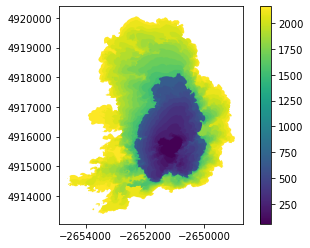

In [72]:
# display fire

fire_file.plot(column='SimTime', legend=True)


### Households

Household data is used to initially place vehicles in proportion to households within census tracts. Households data have been gathered from [US Census Data Table S1101](https://data.census.gov/cedsci/table?q=S1101&tid=ACSST1Y2018.S1101) 2014-2018 American Community Survey 5-Year Estimates, Table S1101. You can download a CSV from the Census Bureau with household data and join to census tract shapefiles that have been also downloaded from the Census Bureau. Althouugh this simulation code expects census tracts, it could be modified to use other geographic areas.

This shapefile contains basic information about the census tract from the Census Bureau and the number of households per census tract has been joined to the shapefile. Important columns here are `Tot_Est_HH`, which contains the ACS estimate of total households per census tract from the above table, and `geometry` with the census tract geometry.

In [81]:
# inspect households

hh_tract = load_shpfile(road_graph, ("households", "Santa_Rosa_tracts_hh.shp"))
hh_tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Santa_Rosa,Santa_Ro_1,Santa_Ro_2,Tot_Est_HH,geometry
0,06,055,201300,06055201300,2013,Census Tract 2013,G5020,S,3825479,6876,+38.3935118,-122.3655355,None,None,NaN,NaN,"POLYGON ((-2625602.592 4895396.940, -2624873.5..."
1,06,055,202000,06055202000,2020,Census Tract 2020,G5020,S,6672855,46827,+38.5814083,-122.5826961,None,None,NaN,NaN,"POLYGON ((-2635488.687 4925562.735, -2635376.7..."
2,06,097,151602,06097151602,1516.02,Census Tract 1516.02,G5020,S,33113703,228016,+38.4218634,-122.5985465,1400000US06097151602,"Census Tract 1516.02, Sonoma County, California",1852.0,1852.0,"POLYGON ((-2646299.185 4912693.434, -2646244.1..."
3,06,097,150607,06097150607,1506.07,Census Tract 1506.07,G5020,S,11093822,0,+38.2766586,-122.6437522,1400000US06097150607,"Census Tract 1506.07, Sonoma County, California",1719.0,1719.0,"POLYGON ((-2657204.756 4892702.043, -2657201.8..."
4,06,097,150610,06097150610,1506.10,Census Tract 1506.10,G5020,S,1349445,0,+38.2654848,-122.6401777,None,None,NaN,NaN,"POLYGON ((-2655973.729 4891745.883, -2655959.1..."


The following cell shows the estimated number of households per census tract in the Santa Rosa area.

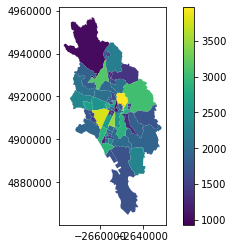

In [24]:
# display households

hh_tract.plot(column="Tot_Est_HH", legend=True)


<a id='scaling_up'></a>
## Scaling Up
([back to Table of Contents](#top))

As one full simulation run using the quickest driving strategy can take approximately 5 hours to run, batch scripting is very useful to obtain simulation results. Two scripts (jobscript.sh and run_jobs.sh) are provided to assist in running batch jobs and are described below. These are currently setup to use the SLURM Workload Manager used by Virtual Roger (Keeling), but can be adjusted to run on other HPC. Note that the code is not parallel, so requesting multiple nodes will not improve performance. 

1. `jobscript.sh` 
	
This file submits one job to the HPC workload manager. It is currently set up to run one simulation for 5 sequential seeds and needs to be called from run_jobs.sh to set the initial seed value.

Before running this file, adjust the time to make sure you have enough time to complete the jobs you want to run. The quickest driving strategy takes the longest to run, and is generally good to figure one job takes approximately 5 hours to run for 800 vehicles. The major roads strategy runs quicker, and the shortest distance strategy runs the fastest.

Make sure you enter in your email address, change the path to the path to the folder that contains all the code provided code, and change the output folder and driving strategies as needed. It is helpful to run a short test run before committing to a large job.

This file calls `run_fireabm.py`, discussed above, which sets up and runs each simulation.

2. `run_jobs.sh`

This is the file that you will submit to the scheduler that will then call `jobscript.sh` multiple times to set up individual jobs. When running this file, make sure your seed increments match the length of the loop in jobscript.sh so that seeds are not run multiple times or skipped. You may want to also change the output and error folders depending on the run.

<a id='analyz_res'></a>
## Analyzing Simulation Results
([back to Table of Contents](#top))

[Graph_Results_Final](./Graph_Results_Final.ipynb) contains the code used to analyze simulation results and generate figures used in the manuscript. The core section of this notebook contains code used to visualize aggregate data from a combination of simulation runs. This is because of the random initial vehicle placement component used in this model; data from each driving strategy is a combination of 100 individual simulation runs each resulting in a slightly different pattern of vehicle traffic.

Refer to that notebook for creating overview maps of the road graph (similar to the ones displayed above for the demo road graph), kernel density maps (videos and stills) for each of the driving strategy combined data at 25 time step intervals, and clearance time graphs and charts.